<a href="https://colab.research.google.com/github/hugojardim/desafio-dt-labs/blob/main/questao-2-colab/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%pip install uv
!uv pip install trimesh

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 108.4 MB/s eta 0:00:00
Using Python 3.11.11 environment at: /usr
Resolved 2 packages in 156ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 51ms
Installed 1 package in 6ms
 + trimesh==4.6.4


Importar libs

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Lambda
from tensorflow.keras.models import Sequential
import cv2
import os
from sklearn.metrics.pairwise import cosine_similarity
import gdown
import trimesh
import zipfile
import random

In [4]:
# Definir seed para reprodutibilidade
seed = 10
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

# Configurações adicionais para garantir reprodutibilidade no TensorFlow
tf.keras.utils.set_random_seed(seed)  # Configura seed para keras, tensorflow e numpy
tf.config.experimental.enable_op_determinism()  # Garante operações determinísticas

Extração dos dados

In [5]:
# Baixar os dados de treino
output_path = '/content/kitti_dataset.zip'
url = f'https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT'

gdown.download(url, output_path, quiet=False)

# Extrair o conteúdo
extract_dir = output_path.replace(".zip", "")
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(output_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Ajuste aqui: usar a pasta "post-processed" dentro do diretório extraído
post_processed_dir = os.path.join(extract_dir, "post-processed")

# Verificar se a pasta existe
if not os.path.exists(post_processed_dir):
    print(f"Pasta 'post-processed' não encontrada em {extract_dir}")
    print(f"Conteúdo do diretório: {os.listdir(extract_dir)}")
else:
    print(f"Pasta 'post-processed' encontrada! Conteúdo: {os.listdir(post_processed_dir)}")


Downloading...
From (original): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT
From (redirected): https://drive.google.com/uc?id=1Mrx0OKnBFteOw1q8IZy-n8x9q8cxZwhT&confirm=t&uuid=fbd54e01-1b60-4b3d-b0f2-ae0edf5d2949
To: /content/kitti_dataset.zip
100%|██████████| 71.4M/71.4M [00:01<00:00, 47.2MB/s]


Pasta 'post-processed' encontrada! Conteúdo: ['Samira_Makhmalbaf', 'Woody_Allen', 'David_Caruso', 'John_Wright', 'Mark_Kelly', 'Thad_Matta', 'Jane_Kaczmarek', 'Laurel_Clark', 'Leonardo_DiCaprio', 'Roy_Williams', 'Peter_Mugyeni', 'Jennifer_Reilly', 'Raul_Rivero', 'Linda_Dano', 'Ben_Braun', 'Keira_Knightley', 'Jim_Bunning', 'Miranda_Otto', 'Alan_Ball', 'Asmaa_Assad', 'Robin_Tunney', 'Lisa_Murkowski', 'Qusai_Hussein', 'Dionne_Warwick', 'Steve_Austin', 'Fran_Drescher', 'Priscilla_Presley', 'Jean-Claude_Juncker', 'Imelda_Marcos', 'Marc-Andre_Fleury', 'Jennifer_Garner', 'Paul_Bremer', 'Oswaldo_Paya', 'Alejandro_Lerner', 'Laurent_Woulzy', 'Raymond_Odierno', 'Yasein_Taher', 'Tom_Cruise', 'Ivan_Stambolic', 'Jorge_Arce', 'Jonathan_Mostow', 'Shigeru_Ishiba', 'Rick_Carlisle', 'Bill_Clinton', 'Dwayne_Wade', 'Jean-Marc_de_La_Sabliere', 'Mike_Scioscia', 'Stuart_Townsend', 'Bill_Cartwright', 'Bob_Hayes', 'George_McCloud', 'Javier_Vazquez', 'Adolfo_Rodriguez_Saa', 'Gloria_Allred', 'Pete_Rose', 'Carlos_

In [6]:
folders = sorted(os.listdir(post_processed_dir))

original_img_dataset = pd.DataFrame(columns=['img', 'id'])

for idx, folder in enumerate(folders):
    folder_path = os.path.join(post_processed_dir, folder)
    if os.path.isdir(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(folder_path, filename)
                img_original = cv2.imread(img_path)
                img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
                try:
                    # Dataset de imagens originais (RGB)
                    original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [idx]})], ignore_index=True)
                except Exception as e:
                    print(f"Erro ao carregar {img_path}: {e}")

print('Número total de imagens carregadas:', len(original_img_dataset))

Número total de imagens carregadas: 12000


In [7]:
def preprocess_image(input_img):
    img = input_img.copy()

    # Calcular altura da imagem original em 60% da parte superior
    original_height = img.shape[0]
    new_height = int(original_height * 0.60)  # Definir altura para manter os 60% superiores
    img = img[:new_height, :]  # Recortar apenas a parte superior

    # Redimensionar para 224x224 mantendo proporção
    target_size = (224, 224)
    h, w = img.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)  # Escala para manter proporção
    resized_h, resized_w = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (resized_w, resized_h))

    # Adicionar bordas (padding) apenas na parte inferior
    pad_top = 0  # Sem padding no topo
    pad_bottom = target_size[0] - resized_h  # Todo padding na parte inferior
    pad_left = 0  # Sem padding à esquerda
    pad_right = target_size[1] - resized_w  # Todo padding à direita

    img_padded = cv2.copyMakeBorder(
        img_resized,
        pad_top,
        pad_bottom,
        pad_left,
        pad_right,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # Preencher bordas com preto
    )

    # Normalizar para [0,1]
    img_normalized = img_padded / 255.0

    return img_normalized


Preparar dados de treinamento

In [8]:
# Criar um novo dataset para as imagens processadas
img_dataset = pd.DataFrame(columns=['img', 'id'])

for idx, row in original_img_dataset.iterrows():
    try:
        # Processar a imagem usando preprocess_image
        processed_img = preprocess_image(row['img'])

        # Adicionar ao dataset de imagens processadas
        img_dataset = pd.concat([img_dataset, pd.DataFrame({'img': [processed_img], 'id': [row['id']]})], ignore_index=True)
    except Exception as e:
        print(f"Erro ao processar imagem com ID {row['id']}: {e}")

print('Número total de imagens processadas:', len(img_dataset))

Número total de imagens processadas: 12000


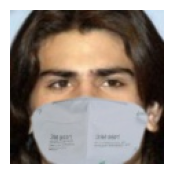

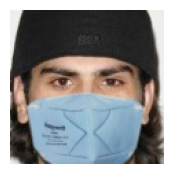

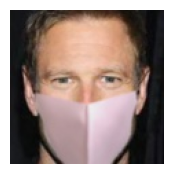

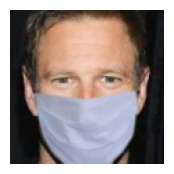

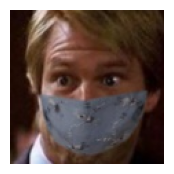

In [9]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(original_img_dataset['img'][i])
    plt.axis('off')
    plt.show()

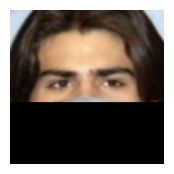

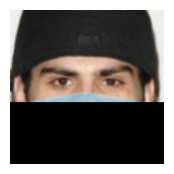

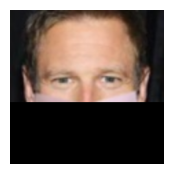

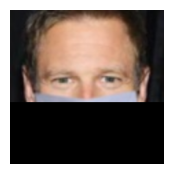

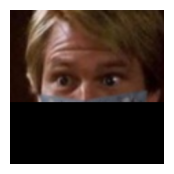

In [10]:
# print first 5 images

for i in range(5):
    plt.figure(figsize=(2, 2))
    plt.imshow(img_dataset['img'][i])
    plt.axis('off')
    plt.show()

In [11]:
X = np.stack(img_dataset['img'].values)
y = img_dataset['id'].values

Configurar modelo

In [12]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Construir o modelo sequencial completo
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dense(128),
    Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Âncora
- É a imagem de referência (ex: uma foto da pessoa A)
- Serve como ponto de comparação para as outras duas imagens

### Positivo
- É outra imagem da **mesma pessoa** da âncora (outra foto da pessoa A)
- Pode ter diferenças como ângulo, iluminação, expressão facial, uso de máscara

### Negativo
- É uma imagem de uma **pessoa diferente** (foto da pessoa B)
- Representa o que o modelo deve aprender a distinguir da âncora

In [13]:
# A classe TripletGenerator é um gerador de dados para o treinamento do modelo
class TripletGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, labels, batch_size=32, num_triplets=5000, **kwargs):
        super().__init__(**kwargs)
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.num_triplets = num_triplets

        # Encontrar classes com pelo menos 2 amostras
        unique_labels, counts = np.unique(labels, return_counts=True)
        self.classes = unique_labels[counts >= 2]

        if len(self.classes) == 0:
            raise ValueError("Não há classes com pelo menos 2 amostras. Impossível criar triplets.")

        self.indexes = np.arange(num_triplets)


    def __len__(self):
        return int(np.ceil(self.num_triplets / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_triplets = []

        for _ in range(len(batch_indexes)):
            # Escolher classe âncora aleatoriamente (apenas entre classes com múltiplas amostras)
            anchor_class = np.random.choice(self.classes)

            # Índices de imagens da mesma classe (positivos)
            positive_indices = np.where(self.labels == anchor_class)[0]

            # Verificar se ainda temos pelo menos 2 imagens nesta classe
            if len(positive_indices) < 2:
                continue

            # Escolher âncora e positivo aleatoriamente da mesma classe
            anchor_idx = np.random.choice(positive_indices)
            positive_candidates = positive_indices[positive_indices != anchor_idx]

            # Verificação extra para garantir que temos positivos após remover o âncora
            if len(positive_candidates) == 0:
                continue

            positive_idx = np.random.choice(positive_candidates)

            # Escolher negativo de outra classe
            negative_classes = self.classes[self.classes != anchor_class]
            # Verificar se temos outras classes disponíveis
            if len(negative_classes) == 0:
                continue

            negative_class = np.random.choice(negative_classes)
            negative_indices = np.where(self.labels == negative_class)[0]
            negative_idx = np.random.choice(negative_indices)

            batch_triplets.append([
                self.images[anchor_idx],
                self.images[positive_idx],
                self.images[negative_idx]
            ])

        # Garantir que temos pelo menos um triplet no batch
        if not batch_triplets:
            # Tenta novamente com outro índice
            return self.__getitem__((idx + 1) % len(self))

        batch_triplets = np.array(batch_triplets)
        triplets_flat = batch_triplets.reshape(-1, 224, 224, 3)
        targets = np.zeros(len(batch_triplets) * 3)

        return triplets_flat, targets

In [14]:
# A loss function triplet_loss calcula a perda triplet, que é uma função que mede a distância entre âncoras, positivos e negativos
# A ideia é minimizar a distância entre âncoras e positivos, enquanto maximiza a distância entre âncoras e negativos
def triplet_loss(y_true, y_pred, alpha=0.2):
	total = tf.shape(y_pred)[0]
	third = total // 3

	anchor = y_pred[0:third]
	positive = y_pred[third:2*third]
	negative = y_pred[2*third:total]

	# Calcular distâncias entre âncora, positivo e negativo
	pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
	neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)

	# Triplet Loss
	basic_loss = pos_dist - neg_dist + alpha
	loss = tf.maximum(basic_loss, 0.0)
	return tf.reduce_mean(loss)

Compilar e treinar o modelo

In [15]:
# Compilar o modelo com a função de perda triplet loss
model.compile(optimizer='adam', loss=triplet_loss)

# Cria o gerador de triplets
triplet_gen = TripletGenerator(X, y, batch_size=32, num_triplets=5000)

# Treina o modelo com o gerador
history = model.fit(
    triplet_gen,
    epochs=10,
    steps_per_epoch=len(triplet_gen),
    verbose=1
)

Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 36s 182ms/step - loss: 0.2021
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - loss: 0.2004
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - loss: 0.1997
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - loss: 0.1997
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.2005
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.1999
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.2002
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - loss: 0.2000
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.2000
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - loss: 0.2000


Criar banco de dados com vetores descritores

In [16]:
# Função para extrair vetores descritores
def extract_features(model, images):
    features = model.predict(images)
    return features

In [17]:
# Extrair características de todas as imagens do dataset
celebrity_features = extract_features(model, X)

# Criar banco de dados de características
feature_database = {
    'features': celebrity_features,
    'labels': y
}

# # Podemos também salvar para uso futuro
# np.save('feature_database.npy', feature_database)

375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step


Adicionar nova pessoa ao banco

In [18]:
# Carregar a imagem da nova pessoa
new_person_path = '/content/marcelinho_no_db.jpg'

url = "https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb"
gdown.download(url, new_person_path, quiet=False)

# Carregar a imagem
img_original = cv2.imread(new_person_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Processar a imagem usando preprocess_image com a imagem já carregada
new_person_img = preprocess_image(img_original)
new_person_img_array = np.expand_dims(new_person_img, axis=0)

# Extrair características
new_person_features = extract_features(model, new_person_img_array)

# Atribuir um novo ID para esta pessoa (após o último ID existente)
new_person_id = np.max(y) + 1

# Adicionar ao banco de dados
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)
feature_database['features'] = np.vstack([feature_database['features'], new_person_features])
feature_database['labels'] = np.append(feature_database['labels'], new_person_id)

print(f"Nova pessoa adicionada ao banco de dados com ID {new_person_id}")


Downloading...
From: https://drive.google.com/uc?id=1EgvzTNEWTXvegURlmJAt8OXOtrKAlQEb
To: /content/marcelinho_no_db.jpg
100%|██████████| 37.5k/37.5k [00:00<00:00, 37.6MB/s]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Nova pessoa adicionada ao banco de dados com ID 2996


Downloading...
From: https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW
To: /content/marcelinho_na_inferencia.jpg
100%|██████████| 87.6k/87.6k [00:00<00:00, 3.15MB/s]


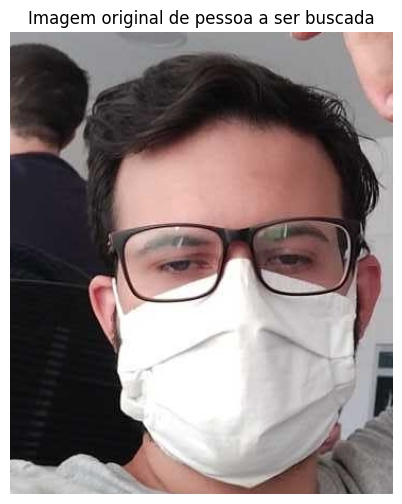

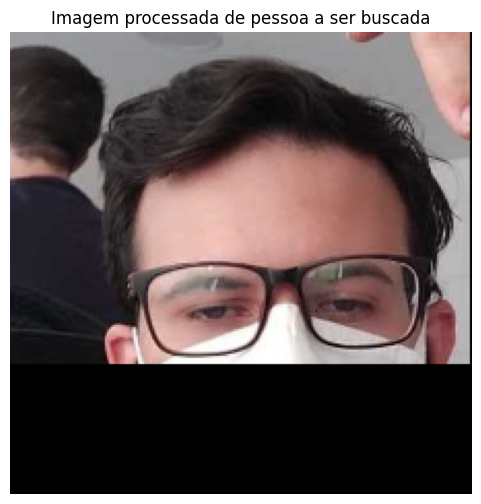

In [19]:
test_image_path = "/content/marcelinho_na_inferencia.jpg"
url = "https://drive.google.com/uc?id=1RcLasSJj-XMke5Fj33adiaHWbbl-9ihW"
gdown.download(url, test_image_path, quiet=False)

# Carregar a imagem
img_original = cv2.imread(test_image_path)
img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

# Adicionar ao banco de dados com imagens originais
original_img_dataset = pd.concat([original_img_dataset, pd.DataFrame({'img': [img_original], 'id': [new_person_id]})], ignore_index=True)

plt.figure(figsize=(6, 6))
plt.imshow(img_original)
plt.title("Imagem original de pessoa a ser buscada")
plt.axis('off')
plt.show()

# Usar a imagem já carregada para o pré-processamento, em vez do caminho do arquivo
test_image = preprocess_image(img_original)
test_image_array = np.expand_dims(test_image, axis=0)

# Exibir a imagem a ser buscada
plt.figure(figsize=(6, 6))
plt.imshow(test_image)
plt.title("Imagem processada de pessoa a ser buscada")
plt.axis('off')
plt.show()


Teste final

In [24]:
# Extrair características da imagem a ser buscada
test_features = extract_features(model, test_image_array)

# Calcular similaridade com todas as faces no banco de dados
# Usamos similaridade de cosseno como métrica que compara a distância entre vetores em um espaço vetorial
# A similaridade de cosseno é uma medida de similaridade entre dois vetores que mede o ângulo entre eles
similarities = cosine_similarity(test_features, feature_database['features'])[0]

# Encontrar a correspondência mais próxima
best_match_idx = np.argmax(similarities)
best_match_id = feature_database['labels'][best_match_idx]
best_match_score = similarities[best_match_idx]

found_img = original_img_dataset['img'][original_img_dataset['id'] == best_match_id].values[0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [21]:
def find_top_matches(test_image_array, model, feature_database, original_img_dataset, top_n=5, specific_id=None):
    # Extrair características da imagem a ser buscada
    test_features = extract_features(model, test_image_array)

    # Sempre calcular o ranking completo para poder exibir a posição global
    full_similarities = cosine_similarity(test_features, feature_database['features'])[0]
    full_ranking = np.argsort(full_similarities)[::-1]

    # Mapeamento do índice para a posição no ranking (para otimização)
    idx_to_rank = {idx: rank+1 for rank, idx in enumerate(full_ranking)}

    if specific_id is not None:
        # Filtrar apenas as características do ID específico
        mask = np.array(feature_database['labels']) == specific_id
        if not np.any(mask):
            print(f"ID {specific_id} não encontrado no banco de dados!")
            return None

        # Índices no conjunto original onde o ID é o específico
        id_indices = np.where(mask)[0]

        # Posições destes índices no ranking geral
        positions_in_ranking = [idx_to_rank[idx] for idx in id_indices]

        # Obter características apenas deste ID
        filtered_features = feature_database['features'][mask]
        similarities = cosine_similarity(test_features, filtered_features)[0]

        # Ordenar por similaridade dentro deste ID específico
        top_indices_within_id = np.argsort(similarities)[::-1][:top_n]
        top_scores = similarities[top_indices_within_id]
        top_ids = [specific_id] * len(top_indices_within_id)

        # Ajustar os índices para o banco de dados original
        original_indices = id_indices[top_indices_within_id]

        # Obter as posições globais para estes índices
        positions = [positions_in_ranking[i] for i in top_indices_within_id]
    else:
        # Usar o ranking completo já calculado
        top_indices = full_ranking[:top_n]
        top_scores = full_similarities[top_indices]
        top_ids = [feature_database['labels'][idx] for idx in top_indices]
        original_indices = top_indices
        positions = list(range(1, len(top_indices) + 1))  # Já estão em ordem 1, 2, 3, ...

    # Determinar quantas correspondências podemos realmente mostrar
    available_matches = len(original_indices)

    # Calcular layout de grade apropriado para visualização
    if available_matches <= 3:
        rows, cols = 1, available_matches
    else:
        cols = min(5, available_matches)  # No máximo 5 colunas
        rows = (available_matches + cols - 1) // cols  # Arredonda para cima

    # Exibir as correspondências encontradas
    if available_matches > 0:
        plt.figure(figsize=(cols*3, rows*3))

        for i, (idx, score, person_id, pos) in enumerate(zip(original_indices, top_scores, top_ids, positions)):
            # Obter a imagem correspondente
            matching_imgs = original_img_dataset[original_img_dataset['id'] == person_id]
            if len(matching_imgs) > 0:
                found_img = matching_imgs['img'].values[0]

                # Criar subplot para cada correspondência
                plt.subplot(rows, cols, i+1)
                plt.imshow(found_img)
                title = f"ID: {person_id}\nScore: {score:.4f}\nRank Global: {pos}"
                plt.title(title)
                plt.axis('off')

        title = f"Top {available_matches} correspondências"
        if specific_id is not None:
            title += f" para ID {specific_id}"

        plt.suptitle(title, fontsize=16)
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)  # Ajusta espaço para o título principal
        plt.show()

        # Exibir também informações em formato de texto
        print(f"{title}:")
        for i, (score, person_id, pos) in enumerate(zip(top_scores, top_ids, positions)):
            print(f"{i+1}. ID {person_id}: Score={score:.4f}, Ranking Global={pos}")

    return {
        'indices': original_indices,
        'scores': top_scores,
        'ids': top_ids,
        'positions': positions
    }


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


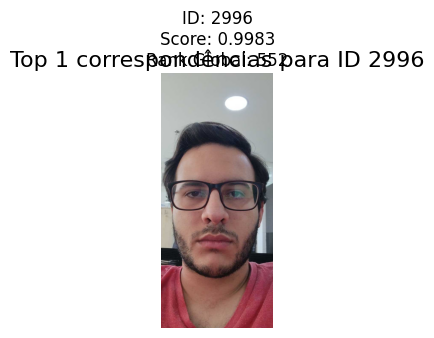

Top 1 correspondências para ID 2996:
1. ID 2996: Score=0.9983, Ranking Global=552


{'indices': array([12000]),
 'scores': array([0.998281], dtype=float32),
 'ids': [2996],
 'positions': [552]}

In [23]:
# Para ver onde o ID 2996 está ranqueado entre todas as imagens
find_top_matches(test_image_array, model, feature_database, original_img_dataset, top_n=1, specific_id=2996)